[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rusla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rusla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
c:\Users\rusla\.conda\envs\multimodal\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\rusla\.conda\envs\multimodal\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Vocabulary size: 164
Vocabulary (word2idx): {'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3, 'a': 4, 'man': 5, 'sits': 6, 'in': 7, 'chair': 8, 'while': 9, 'holding': 10, 'large': 11, 'stuffed': 12, 'animal': 13, 'of': 14, 'lion': 15, '.': 16, 'is': 17, 'sitting': 18, 'on': 19, 'completes': 20, 'the': 21, 'finishing': 22, 'touches': 23, 'holds': 24, 'toy': 25, 'smiling': 26, 'at': 27, 'several': 28, 'men': 29, 'hard': 30, 'hats': 31, 'are': 32, 'operating': 33, 'giant': 34, 'pulley': 35, 'system': 36, 'workers': 37, 'look': 38, 'down': 39, 'from': 40, 'up': 41, 'above': 42, 'piece': 43, 'equipment': 44, 'two': 45, 'working': 46, 'machine': 47, 'wearing': 48, 'four': 49, 'top': 50, 'tall': 51, 'structure': 52, 'three': 53, 'rig': 54, 'an': 55, 'asian': 56, 'black': 57, 'suit': 58, 'stands': 59, 'near': 60, 'dark-haired': 61, 'woman': 62, 'and': 63, 'brown-haired': 64, 'people': 65, 'standing': 66, 'outside': 67, 'pipes': 68, 'metal': 69, 'railing': 70, 'young': 71, 'walks': 72, 'past':

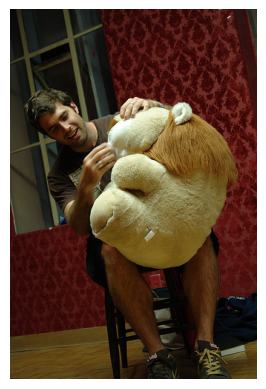

Generated Caption: a man sits in a chair while holding a large stuffed animal of a lion . a man is
Expected Captions:
-  A man sits in a chair while holding a large stuffed animal of a lion.
-  A man is sitting on a chair holding a large stuffed animal.
-  A man completes the finishing touches on a stuffed lion.
-  A man holds a large stuffed lion toy.
-  A man is smiling at a stuffed lion

Testing on a validation image:


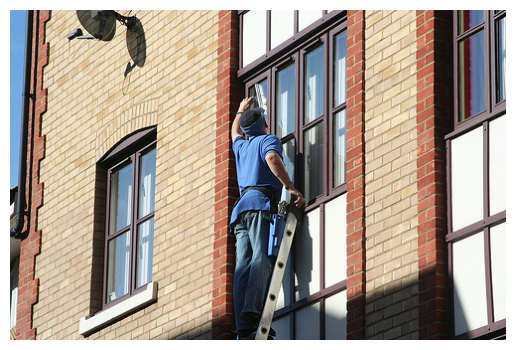

Generated Caption: a child in a pink dress is climbing up a set of stairs in an entry way . a
Expected Captions:
-  Someone in a blue shirt and hat is standing on stair and leaning against a window.
-  A man in a blue shirt is standing on a ladder cleaning a window.
-  A man on a ladder cleans the window of a tall building.
-  Man in blue shirt and jeans on ladder cleaning windows
-  A man on a ladder cleans a window

Testing on a test image:


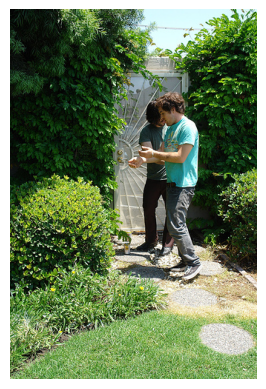

Generated Caption: a girl is on rollerskates talking on her cellphone standing in a parking lot . a trendy girl talking
Expected Captions:
-  Two young guys with shaggy hair look at their hands while hanging out in the yard.
-  Two young, White males are outside near many bushes.
-  Two men in green shirts are standing in a yard.
-  A man in a blue shirt standing in a garden.
-  Two friends enjoy time spent together.


In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge import Rouge
import numpy as np
from datasets import load_dataset
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

# --- Data Loading and Preprocessing (Simplified for Debugging) ---

class ImageCaptionDataset(Dataset):
    def __init__(self, images, captions, vocab, transform=None):
        self.images = images
        self.captions = captions
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].convert('RGB')
        caption_list = self.captions[idx]

        if self.transform:
            image = self.transform(image)

        # Combine all captions into a single string
        combined_caption = " ".join(caption_list)

        # Tokenize and convert caption to numerical form
        tokens = nltk.tokenize.word_tokenize(str(combined_caption).lower())
        caption_vec = []
        caption_vec.append(self.vocab('<start>'))
        caption_vec.extend([self.vocab(token) for token in tokens])
        caption_vec.append(self.vocab('<end>'))
        target = torch.LongTensor(caption_vec)

        return image, target

# --- Vocabulary (Modified for Debugging) ---

class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']  # Return <unk> if word not found
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(captions_list, threshold=1):  # Reduced threshold to 1
    counter = {}
    for captions in captions_list:
        for caption in captions:
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            for word in tokens:
                counter[word] = counter.get(word, 0) + 1

    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    words = [word for word, cnt in counter.items() if cnt >= threshold]
    for word in words:
        vocab.add_word(word)

    return vocab

# --- Model Definition (Simplified) ---

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # Freeze resnet parameters (for initial debugging)
        for param in self.resnet.parameters():
            param.requires_grad = False

    def forward(self, images):
        with torch.no_grad(): # Added no grad since we are not updating resnet weights
          features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, dropout_p=0.0):  # Removed dropout for simplicity
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = 30 # Increased max sequence length

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = nn.utils.rnn.pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False)
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None, max_len=None):
        """
        Generate captions for given image features using greedy search.
        """
        if max_len is None:
            max_len = self.max_seq_length
        
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(max_len):
            hiddens, states = self.lstm(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))  # outputs: (batch_size, vocab_size)
            _, predicted = outputs.max(1)  # predicted: (batch_size)
            sampled_ids.append(predicted)
            
            # Check for end of sequence
            if predicted.item() == self.vocab.word2idx['<end>']:
                break
            
            inputs = self.embed(predicted)  # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)  # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)  # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

# --- Data Preparation (for a few image-caption pairs) ---

# Load the flickr30k dataset and select a subset
flickr_dataset = load_dataset("nlphuji/flickr30k", split="test").select(range(10))

# Split the dataset
train_size = int(0.8 * len(flickr_dataset))
val_size = int(0.1 * len(flickr_dataset))
test_size = len(flickr_dataset) - train_size - val_size

train_val_dataset, test_dataset = random_split(flickr_dataset, [train_size + val_size, test_size])
train_dataset_raw, val_dataset_raw = random_split(train_val_dataset, [train_size, val_size])

# Extract images and their descriptions
def extract_data(dataset):
    images = []
    captions = []
    for i in range(len(dataset)):
        try:
            image = dataset[i]["image"]
            caption_list = dataset[i]["caption"]
            images.append(image)
            captions.append(caption_list)
        except Exception as e:
            print(f"Error processing item {i}: {e}")
    return images, captions

# Extract data for each set
train_images, train_captions = extract_data(train_dataset_raw)
val_images, val_captions = extract_data(val_dataset_raw)
test_images, test_captions = extract_data(test_dataset)


# --- Evaluation Function ---

def get_sentence_from_ids(word_ids, vocab):
    return ' '.join([vocab.idx2word.get(word_id.item(), '<unk>') for word_id in word_ids if word_id not in [vocab('<pad>'), vocab('<start>'), vocab('<end>')]])

def test_model_on_image(encoder, decoder, image_source, image_index, vocab, device, transform, max_len=20):
    if image_source == 'train':
        images = train_images
        captions = train_captions
    elif image_source == 'val':
        images = val_images
        captions = val_captions
    elif image_source == 'test':
        images = test_images
        captions = test_captions
    else:
        raise ValueError("Invalid image_source. Must be 'train', 'val', or 'test'")

    image = images[image_index]
    # Display the image
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    # Preprocess and generate caption
    image = image.convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        features = encoder(image_tensor)
        sampled_ids = decoder.sample(features, max_len=max_len)

    # Convert word IDs back to words
    generated_caption = get_sentence_from_ids(sampled_ids.squeeze(), vocab)
    print("Generated Caption:", generated_caption)

    # Print expected captions
    print("Expected Captions:")
    for cap in captions[image_index]:
        print("- ", cap)

def collate_fn(data):
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)
    images = torch.stack(images, 0)
    lengths = [len(cap) for cap in captions]
    targets = pad_sequence(captions, batch_first=True)
    return images, targets, lengths

# --- Training Setup (for a single iteration) ---
def main():
    # Hyperparameters (for debugging)
    embed_size = 256
    hidden_size = 512
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 50  
    batch_size = 2  
    threshold = 1   # Reduced to include more words in vocabulary

    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.46), (0.229, 0.224, 0.225))
    ])

    # Build vocabulary 
    vocab = build_vocab(train_captions, threshold=threshold)
    vocab_size = len(vocab)
    print(f"Vocabulary size: {vocab_size}")

    # Print vocabulary to check for <unk> issues
    print("Vocabulary (word2idx):", vocab.word2idx)

    # Data Loader 
    train_dataset = ImageCaptionDataset(train_images, train_captions, vocab, transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn)

    # Initialize model, loss, optimizer
    encoder = EncoderCNN(embed_size).to(device)
    decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    decoder.vocab = vocab
    criterion = nn.CrossEntropyLoss()
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
    optimizer = torch.optim.Adam(params, lr=learning_rate)

    # --- Training Loop  ---
    encoder.train()
    decoder.train()
    
    for epoch in range(num_epochs):
        for i, (images, captions, lengths) in enumerate(train_loader):
            images = images.to(device)
            captions = captions.to(device)
            
            # Print captions and lengths to check for preprocessing issues
            #print("Captions (indices):", captions)
            #print("Lengths:", lengths)

            # Forward pass
            features = encoder(images)
            outputs = decoder(features, captions, lengths)

            # Calculate loss
            targets = nn.utils.rnn.pack_padded_sequence(captions, lengths, batch_first=True, enforce_sorted=False).data
            loss = criterion(outputs, targets)
            
            print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {i+1}/{len(train_loader)}, Batch Loss: {loss.item():.4f}')

            # Backward and optimize
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()
            

    # --- Evaluation on the Same Image ---
    # Test on a training image:
    print("Testing on a training image:")
    test_model_on_image(encoder, decoder, 'train', 0, vocab, device, transform)

    # Test on a validation image:
    print("\nTesting on a validation image:")
    test_model_on_image(encoder, decoder, 'val', 0, vocab, device, transform)

    # Test on a test image:
    print("\nTesting on a test image:")
    test_model_on_image(encoder, decoder, 'test', 0, vocab, device, transform)

if __name__ == '__main__':
    nltk.download('punkt')
    nltk.download('wordnet')
    main()